# RPG 2D – Partie II : Documentation technique (Notebook)


Ce notebook regroupe la documentation des **classes**, **attributs** et **méthodes** du corrigé Partie II (création du joueur, des monstres et GUI basique). Il reprend la structure exacte des fichiers fournis et offre une base pour vos annotations.

## Table des matières
1. [Vue d’ensemble & UML textuel](#uml)
2. [constants.py](#constants)
3. [entity.py / Entity](#entity)
4. [player.py / Player](#player)
5. [mob.py / Mob](#mob)
6. [map.py / Map](#map)
7. [gui.py / Gui & QuitButton](#gui)
8. [main.py / My_Game](#main)


## 1) Vue d’ensemble & UML textuel <a id='uml'></a>

```
My_Game (arcade.Window)
 ├─ Map
 ├─ Player (Entity)
 ├─ Mob (Entity)
 └─ Gui
      └─ QuitButton (arcade.gui.UIFlatButton)

Entity (arcade.Sprite)
 ├─ Player
 └─ Mob
```


## 2) `constants.py` <a id='constants'></a>

- **Rôle** : centralise les constantes d’écran, de carte, et les caractéristiques sprites/animations pour le joueur et les orcs.
- **Écran** : `SCREEN_WIDTH`, `SCREEN_HEIGHT`, `SCREEN_TITLE`.
- **Map** : `MAP_FILE`, `MAP_SCALING`, `MAP_WIDTH`, `MAP_HEIGHT`.
- **Player** : dimensions, fichiers (`PLAYER_FILE`, `PLAYER_CARACTERISTICS_FILE`), indices d’animation `PLAYER_WALK_*`, `PLAYER_ATTACK_*`, coordonnées `PLAYER_*_COORDS`, regroupées dans `PLAYER_SPRITE_COORDS`.
- **Orc** : idem (`ORC_FILE`, `MOB_CARACTERISTICS_FILE`, indices `WALK_*`/`ATTACK_*`, coordonnées `ORC_*_COORDS`, regroupées dans `ORC_SPRITE_COORDS`).


## 3) `entity.py` / **Entity** <a id='entity'></a>

**Hérite de** : `arcade.Sprite`

### Attributs
- `file_name: str`, `scaling: float`, `img_width: int`, `img_height: int`, `coords: list[list[tuple[int,int]]]`.
- `textures: list[list[arcade.Texture]]` — animations découpées depuis la sprite sheet.
- `current_texture_indice: int` — frame courante.
- `status: int` — état (ex. direction).
- `attributes: dict` — PV, vitesse, nom, etc.
- `center_x, center_y: float` — position monde.

### Méthodes
- `__init__(...)` : découpe la sprite sheet en textures et initialise l’état.
- `setup()` : compatibilité (chargement déjà fait dans `__init__`).
- `update()` : vide (à surcharger).


## 4) `player.py` / **Player** <a id='player'></a>

**Hérite de** : `Entity`

### Attributs spécifiques
- `init_x_pos`, `init_y_pos` — mémos de la position initiale.

### Méthodes
- `setup()` : lit `PLAYER_CARACTERISTICS_FILE` (JSON) → remplit `attributes`, positionne le joueur (`Init_x/y` * `MAP_SCALING`), texture initiale.
- `update()` : contraint la position aux bornes de la carte (`MAP_WIDTH/HEIGHT` & `MAP_SCALING`), anime selon `change_x/y` et `status` (`PLAYER_WALK_*`).


### Rôle de `change_x` et `change_y`

- Ces deux attributs proviennent de la classe `arcade.Sprite`.
- Ils représentent la **vitesse de déplacement en pixels par frame** :
  - `change_x` : déplacement horizontal (positif = droite, négatif = gauche).
  - `change_y` : déplacement vertical (positif = haut, négatif = bas).
- Dans ce projet :
  - `Player` : `change_x`/`change_y` sont fixés dans `on_key_press` et remis à 0 dans `on_key_release`.
  - `Mob` : `update()` les modifie selon le statut (WALK_LEFT, WALK_RIGHT, …) pour créer un mouvement pseudo-aléatoire.
- Après chaque mise à jour, la position (`center_x`, `center_y`) est incrémentée par ces valeurs.
- Enfin, pour éviter l’inertie infinie, `Mob.update()` remet `change_x, change_y = 0, 0` une fois l’incrément appliqué.


### Schéma visuel : vecteurs de déplacement
Le diagramme ci-dessous illustre le sens des déplacements selon les valeurs de `change_x` et `change_y`.
- `change_x > 0` : déplacement vers la droite ; `change_x < 0` : vers la gauche.
- `change_y > 0` : déplacement vers le haut ; `change_y < 0` : vers le bas.
- La position (`center_x`, `center_y`) est incrémentée à chaque frame par ces valeurs.

> Astuce : pour obtenir une vitesse indépendante du framerate, on peut multiplier par `delta_time`.

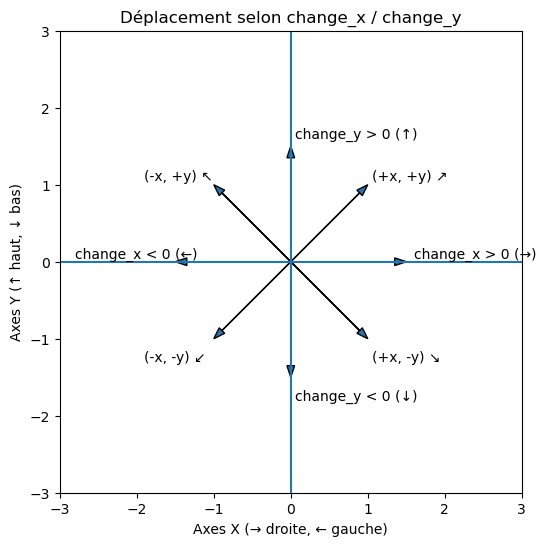

In [1]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Déplacement selon change_x / change_y")

# Axes
ax.axhline(0)
ax.axvline(0)

# Example arrows (one chart, default styles)
# Right (change_x > 0)
ax.arrow(0, 0, 1.5, 0, head_width=0.1, length_includes_head=True)
ax.text(1.6, 0.05, "change_x > 0 (→)", fontsize=10)

# Left (change_x < 0)
ax.arrow(0, 0, -1.5, 0, head_width=0.1, length_includes_head=True)
ax.text(-2.8, 0.05, "change_x < 0 (←)", fontsize=10)

# Up (change_y > 0)
ax.arrow(0, 0, 0, 1.5, head_width=0.1, length_includes_head=True)
ax.text(0.05, 1.6, "change_y > 0 (↑)", fontsize=10)

# Down (change_y < 0)
ax.arrow(0, 0, 0, -1.5, head_width=0.1, length_includes_head=True)
ax.text(0.05, -1.8, "change_y < 0 (↓)", fontsize=10)

# Diagonals (combined movement)
ax.arrow(0, 0, 1.0, 1.0, head_width=0.1, length_includes_head=True)
ax.text(1.05, 1.05, "(+x, +y) ↗", fontsize=10)

ax.arrow(0, 0, -1.0, 1.0, head_width=0.1, length_includes_head=True)
ax.text(-1.9, 1.05, "(-x, +y) ↖", fontsize=10)

ax.arrow(0, 0, 1.0, -1.0, head_width=0.1, length_includes_head=True)
ax.text(1.05, -1.3, "(+x, -y) ↘", fontsize=10)

ax.arrow(0, 0, -1.0, -1.0, head_width=0.1, length_includes_head=True)
ax.text(-1.9, -1.3, "(-x, -y) ↙", fontsize=10)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("Axes X (→ droite, ← gauche)")
ax.set_ylabel("Axes Y (↑ haut, ↓ bas)")

plt.show()


## 5) `mob.py` / **Mob** <a id='mob'></a>

**Hérite de** : `Entity`

### Attributs spécifiques
- `init_x_pos`, `init_y_pos` — position départ.
- `init_count_tick_move` — compteur cible (50–200).
- `current_count_tick_move` — progression courante.

### Méthodes
- `set_name(name)` : fixe `attributes['Name']`.
- `set_init_position(x, y)` : place le mob en monde (`* MAP_SCALING`).
- `setup()` : lit `MOB_CARACTERISTICS_FILE` (JSON) selon `Name` → remplit `attributes`.
- `update()` : anime le mob, gère déplacements pseudo-aléatoires (état `WALK_*`), met à jour la texture.


## 6) `map.py` / **Map** <a id='map'></a>

### Attributs
- `game` — référence à la fenêtre principale.
- `tile_map` — carte chargée via `arcade.load_tilemap`.
- `walls` — listes de calques collision.

### Méthodes
- `setup()` : charge la carte JSON `MAP_FILE` avec `MAP_SCALING` et active des collisions sur certains calques (`use_spatial_hash`).
- `set_collisions()` : crée `arcade.PhysicsEngineSimple(game.player, walls)`.


## 7) `gui.py` / **Gui** & **QuitButton** <a id='gui'></a>

### QuitButton (`arcade.gui.UIFlatButton`)
- `set_window(game)` — enregistre la fenêtre.
- `on_click(event)` — `game.close()`.

### Gui
**Attributs** : `game`, `manager` (UIManager), `anchor` (UIAnchorLayout), `menu_bar`, `player_box`, `clicked_mob_box`.

**Méthodes** :
- `create_game_menu()` — bouton Quit.
- `create_player_box()` — portrait + `Name`/`HitPoints` du joueur.
- `create_clicked_mob_box(clicked_mob)` — idem pour le mob cliqué.
- `setup()` — construit la scène UI par défaut.
- `add_clicked_mob(clicked_mob)` — reconstruit la scène UI avec la box du mob sélectionné.
- `draw()` — dessine l’UI via `manager.draw()`.


## 8) `main.py` / **My_Game** <a id='main'></a>

**Hérite de** : `arcade.Window`

### Attributs
- `map: Map`, `scene`, `physics_engine`, `camera`, `player: Player`, `mobs: list[Mob]`, `sprites_list: arcade.SpriteList`, `gui: Gui`.

### Cycle de vie & méthodes
- `setup()` :
  1. couleur fond, `Camera2D` et `match_window()`
  2. `Map.setup()` → `scene = arcade.Scene.from_tilemap(map.tile_map)`
  3. crée `sprites_list`, instancie `Player` (+ `setup`) puis 15 `Mob` (nom, position aléatoire, `setup`)
  4. `map.set_collisions()` → moteur physique (joueur vs walls)
  5. `Gui(self).setup()`
- `on_key_press/release` : gère `change_x/change_y` selon `Speed`.
- `on_mouse_press` : transforme coord. écran → monde, récupère sprite cliqué, met à jour la GUI.
- `on_update(dt)` : `physics_engine.update()` puis `player.update()` et `mob.update()`, recadre caméra.
- `on_draw()` : clear → `scene.draw()` → `sprites_list.draw()` → `gui.draw()`.
